In [1]:
MAX_EPOCHS = 20000
PATIENCE = 400
normalize = False

ITEM = "Twisted bow"

INPUT_WIDTH=30
LABEL_WIDTH=30

LABEL_COLUMNS=['average','avgHighPrice', 'avgLowPrice']
# LABEL_COLUMNS=['average','avgHighPrice', 'avgLowPrice','lowPriceVolume', 'highPriceVolume']
# LABEL_COLUMNS=['average']
CONV_WIDTH = 30 # given x stamps, predict 1 in the future


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf

import DateTimeHelper
import HistoricalDataHelper

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Get Data

In [3]:
df = DateTimeHelper.getDT(ITEM, "6h")
df

,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,average
timestamp,,,,,
2023-01-08 12:00:00,1.287021e+09,1283452861,50,51,1.285219e+09
2023-01-08 18:00:00,1.286545e+09,1283327601,56,64,1.284829e+09
2023-01-09 00:00:00,1.286230e+09,1282355630,67,68,1.284278e+09
2023-01-09 06:00:00,1.286914e+09,1284695141,32,26,1.285920e+09
2023-01-09 12:00:00,1.292558e+09,1286959997,32,49,1.289171e+09
...,...,...,...,...,...
2023-04-08 12:00:00,1.390931e+09,1387332968,56,51,1.389216e+09
2023-04-08 18:00:00,1.390859e+09,1387869209,92,101,1.389295e+09
2023-04-09 00:00:00,1.390970e+09,1387615092,53,83,1.388923e+09


## Append Historical Data

In [4]:
# import the Historical data
test = HistoricalDataHelper.get_historical(ITEM)
print(test.empty)

False


In [5]:
if not test.empty:
    test = test.transpose()
    test = test[['avgHighPrice', 'avgLowPrice', 'highPriceVolume', 'lowPriceVolume']]
    test= DateTimeHelper.addAverage(test)
    test.index.name = "timestamp"
    # now we append the historical data to the curr data
    # df = df.append(test)
    df = pd.concat([df,test])
    df

# Prepare Data

In [6]:
df2 = df.copy()

layer = tf.keras.layers.Normalization(invert=True)
layer.adapt(df)

df = DateTimeHelper.addAverage(df)

if(normalize):
    df = tf.keras.utils.normalize(df)

print(np.any(np.isnan(df)))
df

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-09 13:53:55.166475: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


False


,avgHighPrice,avgLowPrice,highPriceVolume,lowPriceVolume,average
timestamp,,,,,
2023-01-08 12:00:00,1.287021e+09,1283452861,50,51,1.285219e+09
2023-01-08 18:00:00,1.286545e+09,1283327601,56,64,1.284829e+09
2023-01-09 00:00:00,1.286230e+09,1282355630,67,68,1.284278e+09
2023-01-09 06:00:00,1.286914e+09,1284695141,32,26,1.285920e+09
2023-01-09 12:00:00,1.292558e+09,1286959997,32,49,1.289171e+09
...,...,...,...,...,...
2021-04-12 12:00:00,1.068588e+09,1068134805,119,122,1.068359e+09
2021-04-11 12:00:00,1.069503e+09,1069155670,112,139,1.069311e+09
2021-04-10 12:00:00,1.066879e+09,1066398349,164,152,1.066648e+09


In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

df = df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df = df.sort_index()

n = len(df)
print(n)
print(len(df2))
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
og_test_df = df2[int(n*0.9):]

num_features = df.shape[1]

994
994


# Window Generator Class

In [8]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    # self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [9]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [10]:
def plot(self, model=None, plot_col='average', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [11]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [12]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# ML

## Define Fit

In [13]:
def compile_and_fit(model:tf.keras.models.Sequential, window, patience=PATIENCE):
# Include the epoch in the file name (uses `str.format`)
  checkpoint_path = "Models/cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)
  
  batch_size = 32
  
  # Create a callback that saves the model's weights every  MAX_EPOCHS/10 epochs
  cp_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_path, 
      verbose=1, 
      save_weights_only=True,
      save_freq=int(MAX_EPOCHS/10))
  
  early_stopping1 = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=patience,
                                                    start_from_epoch=MAX_EPOCHS/5,
                                                    mode='min')
  early_stopping2 = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error',
                                                    patience=patience,
                                                    start_from_epoch=MAX_EPOCHS/5,
                                                    mode='min')
  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping1, early_stopping2, cp_callback])
  return history

## Setup ML/Windows

In [14]:
window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=1,
    label_columns=LABEL_COLUMNS)
window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['average', 'avgHighPrice', 'avgLowPrice']

In [15]:
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['average'])
conv_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['average']

In [16]:
# LABEL_WIDTH = 24
# INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width= LABEL_WIDTH + (CONV_WIDTH - 1),
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['average'])

wide_conv_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['average']

# Linear

In [17]:
# linear
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [18]:
try:
    linear = tf.keras.models.load_model('Models/Linear')
except:
    history = compile_and_fit(linear, window)

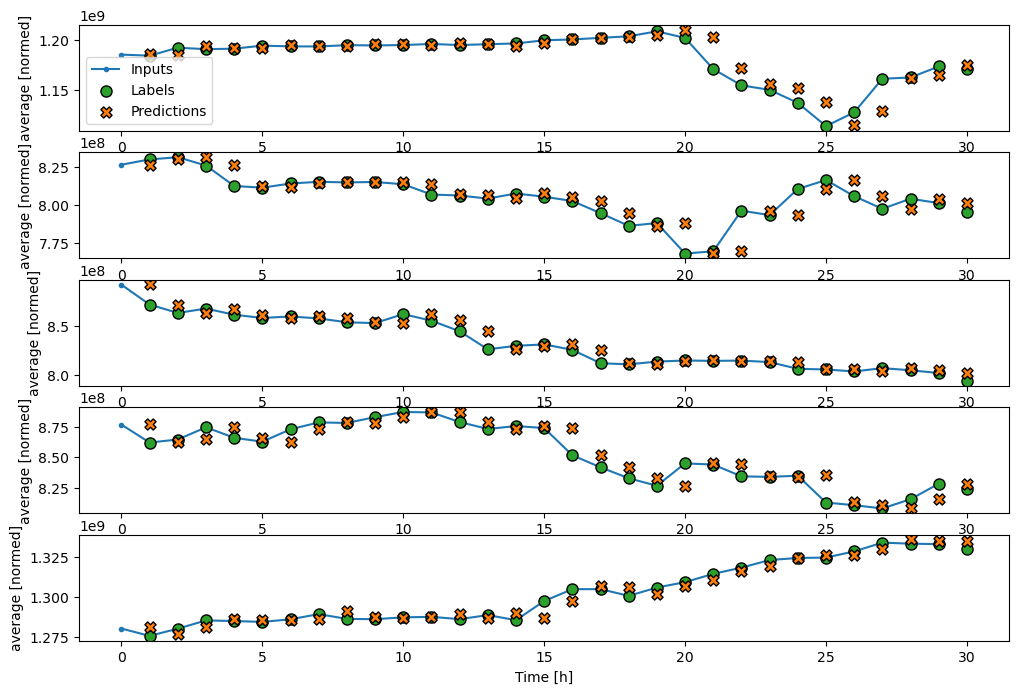

In [19]:
window.plot(linear)

In [20]:
linear.save('Models/Linear')

INFO:tensorflow:Assets written to: Models/Linear/assets


# Multi-Step Dense

In [21]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [22]:
try:
    multi_step_dense = tf.keras.models.load_model('Models/Multi_Step_Dense')
except:
    history = compile_and_fit(multi_step_dense, conv_window)


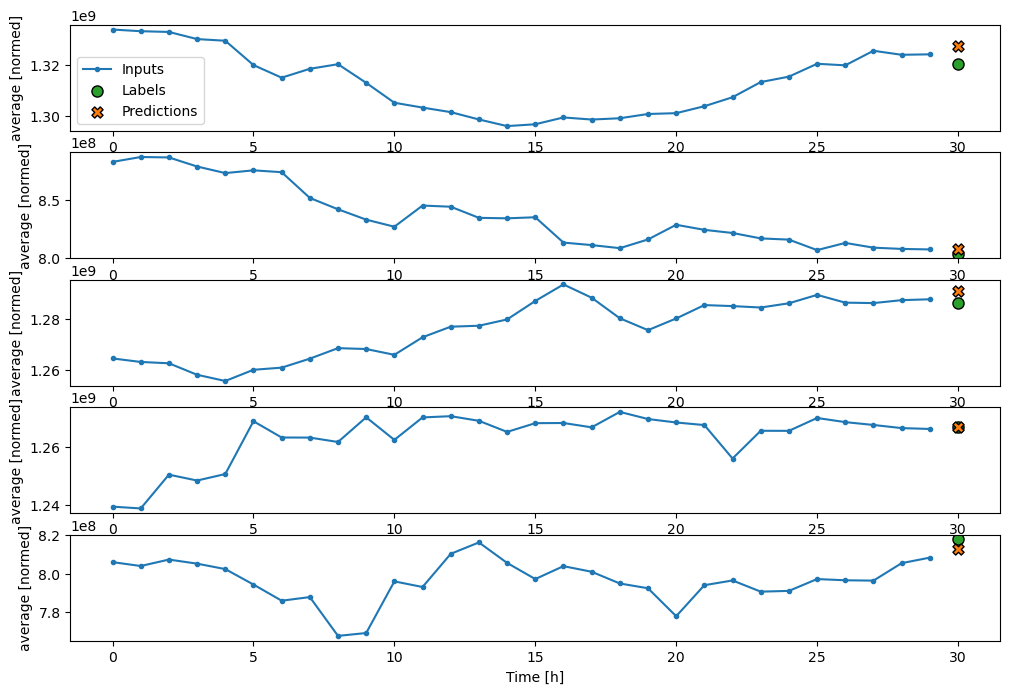

In [23]:
conv_window.plot(multi_step_dense)

In [24]:
multi_step_dense.save('Models/Multi_Step_Dense')

INFO:tensorflow:Assets written to: Models/Multi_Step_Dense/assets


# Conv1D

In [25]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu',
                           input_shape=(None, 5)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [26]:
try:
    conv_model = tf.keras.models.load_model('Models/Conv_model')
except:
    history = compile_and_fit(conv_model, conv_window)

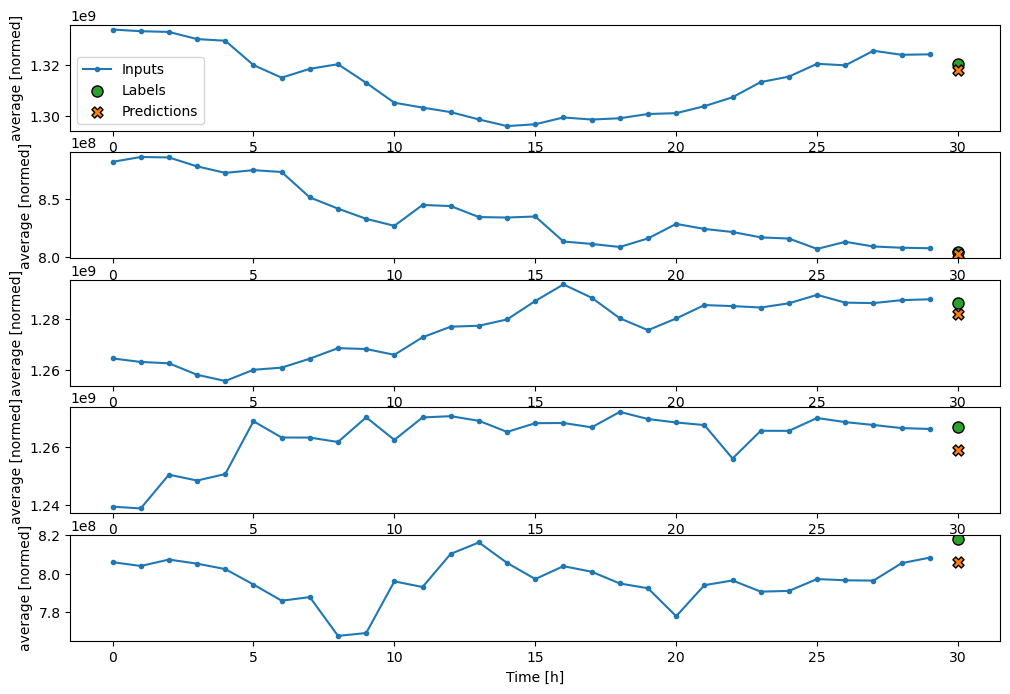

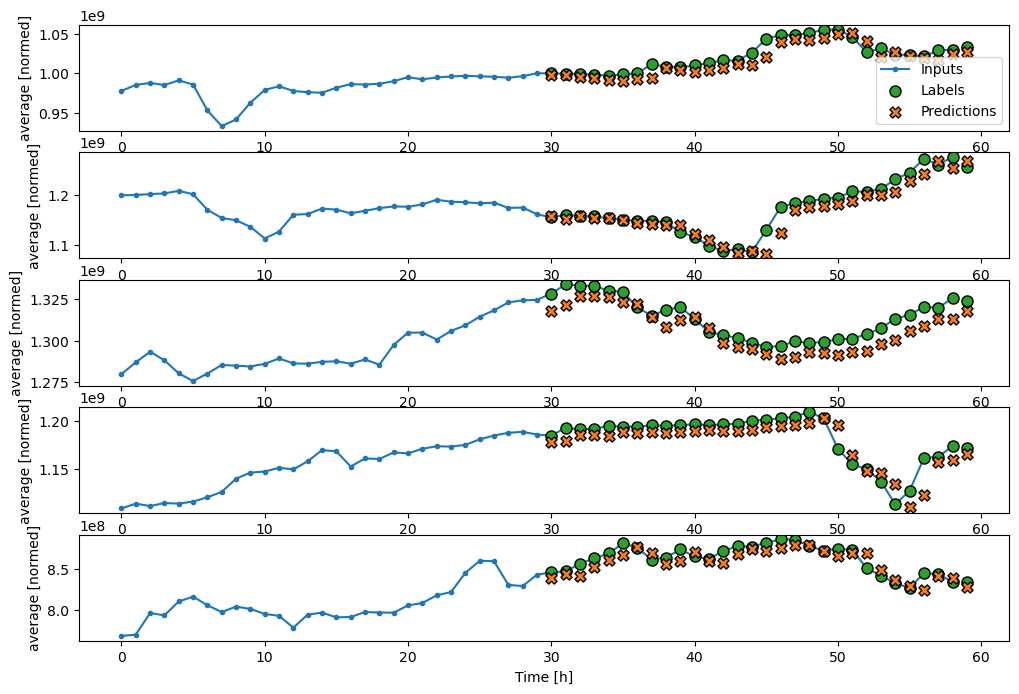

In [27]:
conv_window.plot(conv_model)
wide_conv_window.plot(conv_model)

In [28]:
conv_model.save('Models/Conv_Model')

INFO:tensorflow:Assets written to: Models/Conv_Model/assets


INFO:tensorflow:Assets written to: Models/Conv_Model/assets


(1, 100, 5)
1/1 [==============================] - 0s 102ms/step
[[[1.3488643e+09]
  [1.3485842e+09]
  [1.3482634e+09]
  [1.3438838e+09]
  [1.3499500e+09]
  [1.3573117e+09]
  [1.3667907e+09]
  [1.3685103e+09]
  [1.3682634e+09]
  [1.3680589e+09]
  [1.3682341e+09]
  [1.3726958e+09]
  [1.3741116e+09]
  [1.3745485e+09]
  [1.3763587e+09]
  [1.3735981e+09]
  [1.3717138e+09]
  [1.3721057e+09]
  [1.3710108e+09]
  [1.3690524e+09]
  [1.3649761e+09]
  [1.3669734e+09]
  [1.3691645e+09]
  [1.3691190e+09]
  [1.3674737e+09]
  [1.3673900e+09]
  [1.3636498e+09]
  [1.3545275e+09]
  [1.3573336e+09]
  [1.3560954e+09]
  [1.3580769e+09]
  [1.3573204e+09]
  [1.3572065e+09]
  [1.3588525e+09]
  [1.3616003e+09]
  [1.3618222e+09]
  [1.3606065e+09]
  [1.3617812e+09]
  [1.3628106e+09]
  [1.3637252e+09]
  [1.3636296e+09]
  [1.3639418e+09]
  [1.3671642e+09]
  [1.3695773e+09]
  [1.3679885e+09]
  [1.3690836e+09]
  [1.3703444e+09]
  [1.3706437e+09]
  [1.3724517e+09]
  [1.3744822e+09]
  [1.3780140e+09]
  [1.3789174e+09]

<Axes: xlabel='timestamp'>

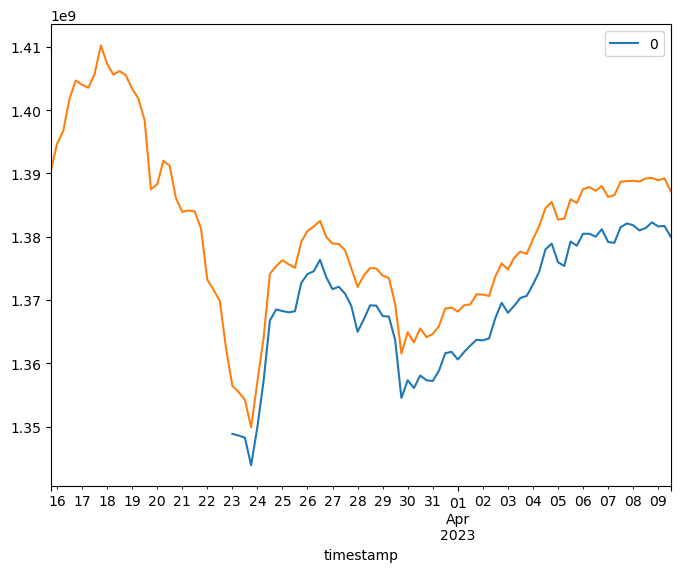

In [29]:
# now we are going to create the test data:

t = test_df.to_numpy()
t_reshaped = t.reshape((1,-1,5))
print(t_reshaped.shape)

# Now X_train has shape (None, 5, 1), which is compatible with Conv1D layer


y_pred = conv_model.predict(t_reshaped)

print(y_pred)

for i in range(len(y_pred[0])):

    # if normalize:
        # print("" + str(np.array(layer(y_pred[i]))[0][4]) + " vs " + str(np.array(layer(test_df['average'][i]))[0][4]) + " vs " + str(og_test_df['average'][i]))
    # else:
        # print("" + str(y_pred[i][0]) + " vs " + str(test_df['average'][i]))
    print("" + str(y_pred[0][i][0]) + " vs " + str(test_df['average'][i]))

p = pd.DataFrame(y_pred[0])
p = p.reset_index()
for i in range(len(p)):
    p.loc[i,'index'] = test_df.index[i+CONV_WIDTH-1]
p= p.set_index('index')

p.plot()
test_df['average'].plot()

In [30]:
new_model = tf.keras.models.load_model('Models/Linear')